In [1]:
import pandas as pd
import numpy as np
import time
import os
from ast import literal_eval
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme(color_codes=True)

In [2]:
df_orig = pd.read_csv('games_with_cp_metrics.csv')
print(df_orig.shape)
df_orig.head()

(30976, 11)


,event,site,round,date,player,elo,color,opponent,result,avg_cp_loss,std_cp_loss
0,US Amateur Team East,Parsipanny USA,1,2002.02.16,"Caruana,F",2032.0,black,"Milovanovic,Dragan",draw,34.440000,43.936390
1,New York State-ch,Kerhonkson USA,1,2002.08.31,"Caruana,F",2040.0,black,"Simon,Jerry C",draw,46.000000,88.329739
2,New York State-ch,Kerhonkson USA,3,2002.09.01,"Dolgitser,K",2262.0,white,"Caruana,F",won,47.589744,100.842786
3,New York State-ch,Kerhonkson USA,3,2002.09.01,"Caruana,F",2040.0,black,"Dolgitser,K",lost,68.131579,134.498908
4,New York State-ch,Kerhonkson USA,4,2002.09.01,"Caruana,F",2040.0,white,"Agaian,Sarkis",won,38.916667,49.042145


In [3]:
# df_orig[df_orig['player'].str.contains('Carlsen')].sort_values(['elo']).tail(40)

In [25]:
def create_tiers(start: int, end: int, size: int = 25) -> dict:
    tier_ranges = {}
    while start < end:
        tier_ranges[range(start, start+size)] = start
        start += size
    return tier_ranges

def get_tier(value: int, tiers: dict) -> int:
    for k, v in tiers.items():
        if value in k:
            return v
    return None

def add_tiers_to_df(df_: pd.DataFrame, start_elo: int, end_elo: int, tier_size=50) -> pd.DataFrame:
    df = df_.copy()
    tier_ranges = create_tiers(start=start_elo, end=end_elo, size=tier_size)
    df['tier'] = df['elo'].apply(lambda x: get_tier(x, tier_ranges))
    return df

def get_acpl_and_stdcpl_by_tier(df: pd.DataFrame) -> pd.DataFrame:
    grouped_agg = df.groupby(['tier'])[['avg_cp_loss', 'std_cp_loss']].mean().reset_index()
    return grouped_agg[['tier', 'avg_cp_loss', 'std_cp_loss']]


def plot_acpl_and_stdcpl_by_tier(df_: pd.DataFrame, player: str = 'all'):
    df = df_.copy()
    if player != 'all':
        df = df[df['player'].str.contains(player)].copy()
    
    player_acpl_and_stdcpl_by_tier = get_acpl_and_stdcpl_by_tier(df)
    if len(player_acpl_and_stdcpl_by_tier) == 0:
        print(f'Found no games for player: {player}.')

    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.regplot(x='tier', y='avg_cp_loss', data=player_acpl_and_stdcpl_by_tier, ax=axes[0], line_kws={'color':'red'})
    corr = player_acpl_and_stdcpl_by_tier[['tier', 'avg_cp_loss']].corr().iloc[0, 1]
    axes[0].set_title(f'Avg CP loss vs Rating | Corr: {corr:.3f}');

    sns.regplot(x='tier', y='std_cp_loss', data=player_acpl_and_stdcpl_by_tier, ax=axes[1], line_kws={'color':'red'})
    corr = player_acpl_and_stdcpl_by_tier[['tier', 'std_cp_loss']].corr().iloc[0, 1]
    axes[1].set_title(f'Std CP loss vs Rating | Corr: {corr:.3f}')
    plt.suptitle(player)
    plt.show();

In [26]:
relevant_players = [
    'Anand', 
    'Aronian', 
    'Carlsen', 
    'Caruana', 
    'Ding', 
    'Duda', 
    'So', 
    'Polgar', 
    'Nepo', 
    'Jobava', 
    'Firouzja', 
    'Sarin',
    'Niemann',
    'Pragg',
    'Gukesh',
    'Keymer',
]

#### Filter out unrelevant players 

In [27]:
df = df_orig.copy()
print(f'Num players: {len(df["player"].unique())}')

Num players: 3998


However, this also includes the opponents of the relevant players.  
Also, some of the relevant players are represented with somewhat different naming format for different games,    
and there are some players that share last name with some of the relevant players.  
A manual filtering is required to make sure we only keep games of the players we want. 

In [28]:
def print_num_games_of_players(df: pd.DataFrame, players: List[str]):
    for player in players:
        print(f'---------- {player} ----------')
        print(df[df['player'].apply(lambda x: x.lower()).str.contains(player.lower())]['player'].value_counts())

In [29]:
print_num_games_of_players(df, relevant_players)

---------- Anand ----------
Anand, Viswanathan    1039
Anand,V                763
Praggnanandhaa R,      459
Praggnanandhaa,R        20
Pranav, Anand            5
Anand Nadar,             2
Saurabh,Anand            1
Poobesh Anand,S          1
Name: player, dtype: int64
---------- Aronian ----------
Aronian,L         1421
Aronian, Levon     215
Name: player, dtype: int64
---------- Carlsen ----------
Carlsen,M          1481
Carlsen, Magnus      16
Carlsen,H             1
Name: player, dtype: int64
---------- Caruana ----------
Caruana,F           1656
Caruana, Fabiano       7
Name: player, dtype: int64
---------- Ding ----------
Ding Liren    977
Ding,L          2
Dinger,F        1
Name: player, dtype: int64
---------- Duda ----------
Duda,J                 889
Duda, Jan Krzysztof     13
Name: player, dtype: int64
---------- So ----------
So,W                         1127
Robson,R                       17
Sokolov,I                      17
Nguyen Ngoc Truong Son         15
Maghsoodloo, 

In [30]:
keep_names = set([
    'Anand, Viswanathan',
    'Anand,V',
    'Aronian,L',
    'Aronian, Levon',
    'Carlsen,M',
    'Caruana,F',
    'Ding Liren',
    'Duda,J',
    'So,W',
    'Polgar, Judit',
    'Nepomniachtchi,I',
    'Jobava,Ba',
    'Firouzja,Alireza',
    'Nihal Sarin,',         # Yep, there is an extra comma for some players
    'Niemann, Hans Moke',
    'Praggnanandhaa R,',
    'Gukesh D,',             
    'Keymer, Vincent',
])

In [31]:
df = df[df['player'].apply(lambda x: x.strip()).isin(keep_names)]
df['player'] = df['player'].apply(lambda x: x.split(',')[0])
df.loc[df['player'] == 'Praggnanandhaa R', 'player'] = 'Praggnanandhaa'
df.loc[df['player'] == 'Gukesh D', 'player'] = 'Gukesh'
df.loc[df['player'] == 'Nihal Sarin', 'player'] = 'Sarin'
df.loc[df['player'] == 'Ding Liren', 'player'] = 'Ding'

In [32]:
df['player'].value_counts()

Anand             1802
Caruana           1656
Aronian           1636
Carlsen           1481
Jobava            1351
Nepomniachtchi    1214
So                1127
Ding               977
Duda               889
Polgar             787
Firouzja           623
Niemann            490
Sarin              484
Gukesh             476
Praggnanandhaa     459
Keymer             369
Name: player, dtype: int64

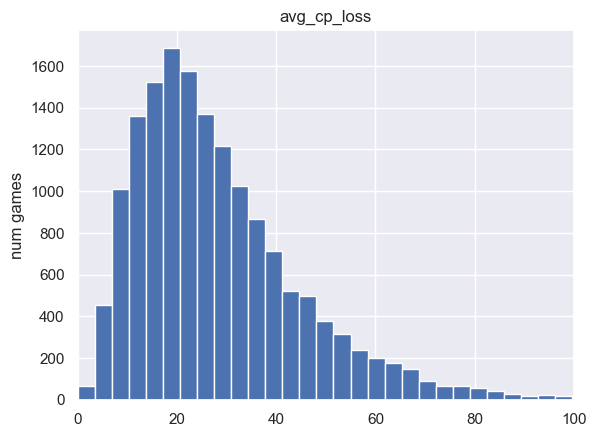

In [33]:
df.hist(column='avg_cp_loss', bins=100)
plt.ylabel('num games')
plt.xlim(0, 100.0);

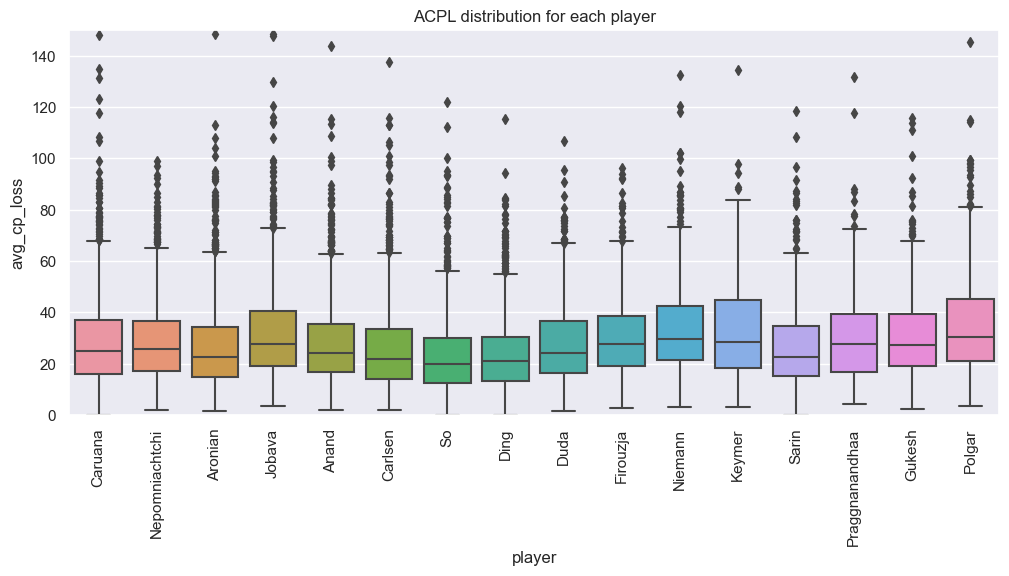

In [75]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(data=df, x="player", y="avg_cp_loss")
plt.title('ACPL distribution for each player')
plt.ylim(0, 150)
plt.xticks(rotation=90);

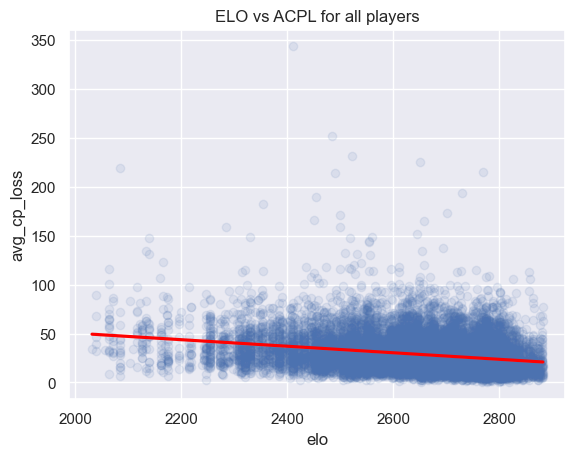

In [57]:
sns.regplot(data=df, x='elo', y='avg_cp_loss', line_kws={'color':'red'}, scatter_kws={'alpha': 0.1})
plt.title('ELO vs ACPL for all players');

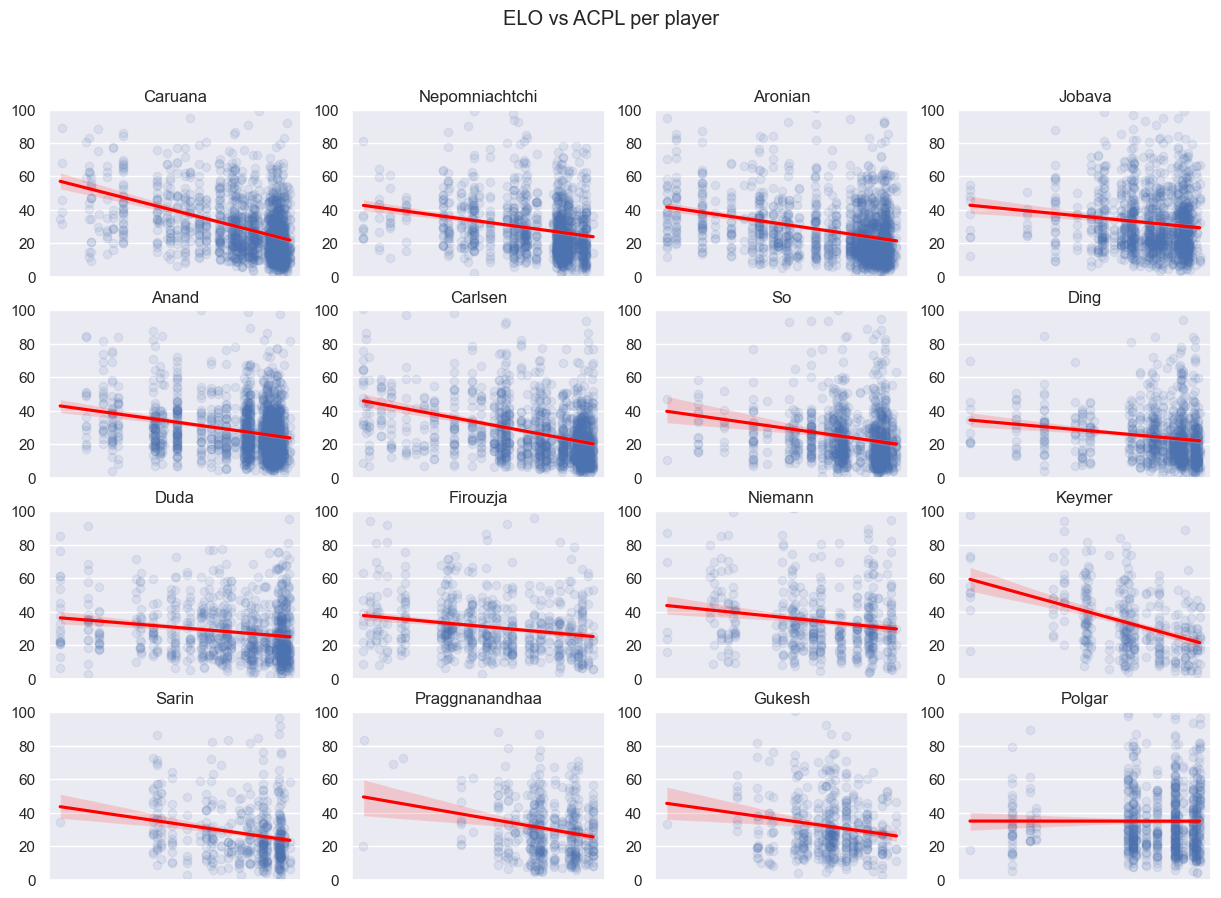

In [74]:
players = df['player'].unique()
num_players = len(players)
num_cols = 4
num_rows_needed = (num_players+1) // num_cols
figure, axes = plt.subplots(num_rows_needed, num_cols, figsize=(15, 10))
figure.suptitle('ELO vs ACPL per player')
for row in range(num_rows_needed):
    for col in range(num_cols):
        sns.regplot(data=df[df['player'] == players[num_cols*row + col]], x='elo', y='avg_cp_loss', line_kws={'color':'red'}, scatter_kws={'alpha': 0.1}, ax=axes[row][col])
        axes[row][col].set_ylim([0, 100])
        axes[row][col].title.set_text(players[num_cols*row + col])
        axes[row][col].set_xticks([])
        axes[row][col].set_xlabel('')
        axes[row][col].set_ylabel('')
        

In [52]:
start_elo, end_elo = 2000, 2900
tier_size = 50
df = add_tiers_to_df(df, start_elo, end_elo, tier_size)

#### Num games per tier

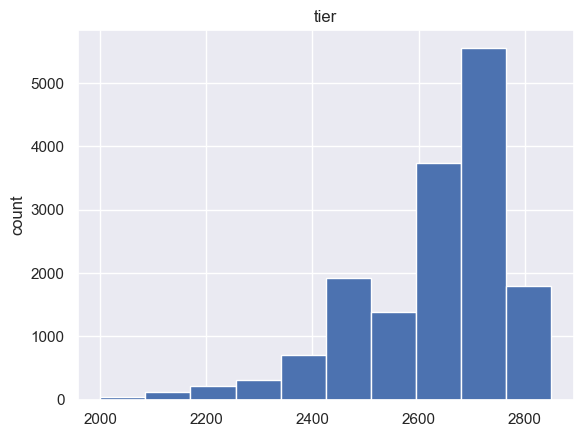

In [36]:
df.hist('tier')
plt.ylabel('count')
plt.show();

#### Num games per tier per player

/var/folders/r7/3_z3p06n3m79fcylhf7268r00000gn/T/ipykernel_32671/723142817.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist('tier', by='player', ax=ax);


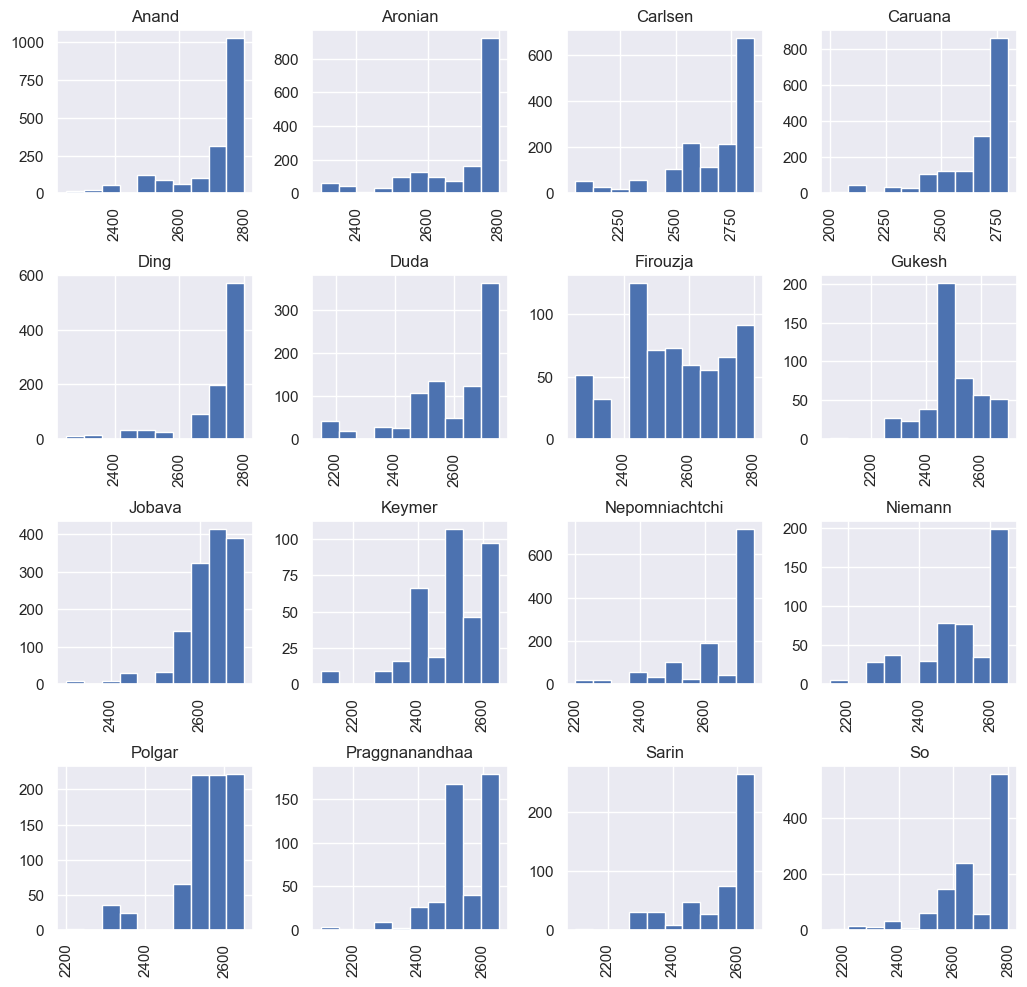

In [37]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
df.hist('tier', by='player', ax=ax);

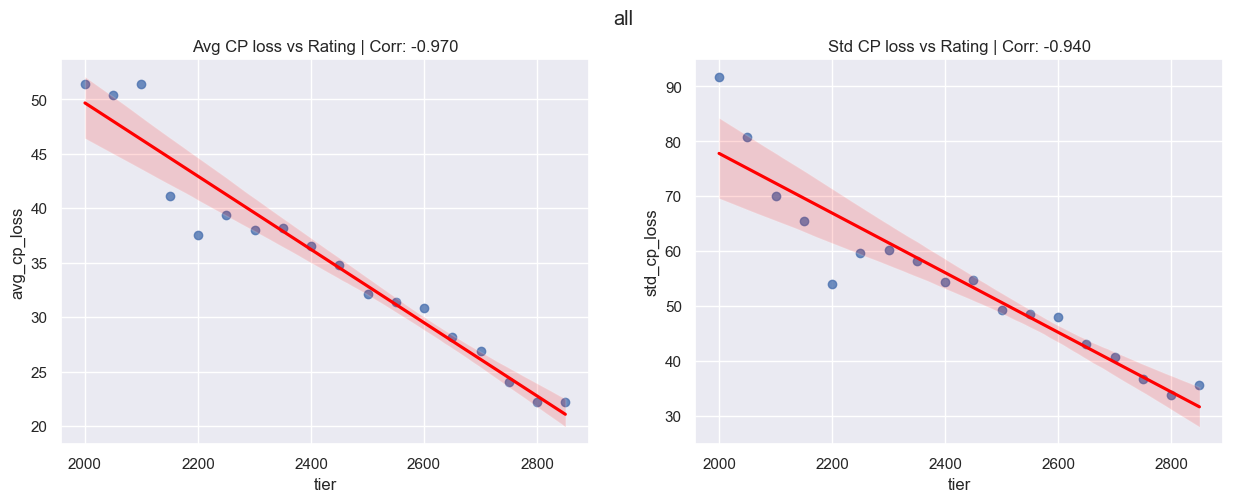

In [38]:
plot_acpl_and_stdcpl_by_tier(df, 'all')

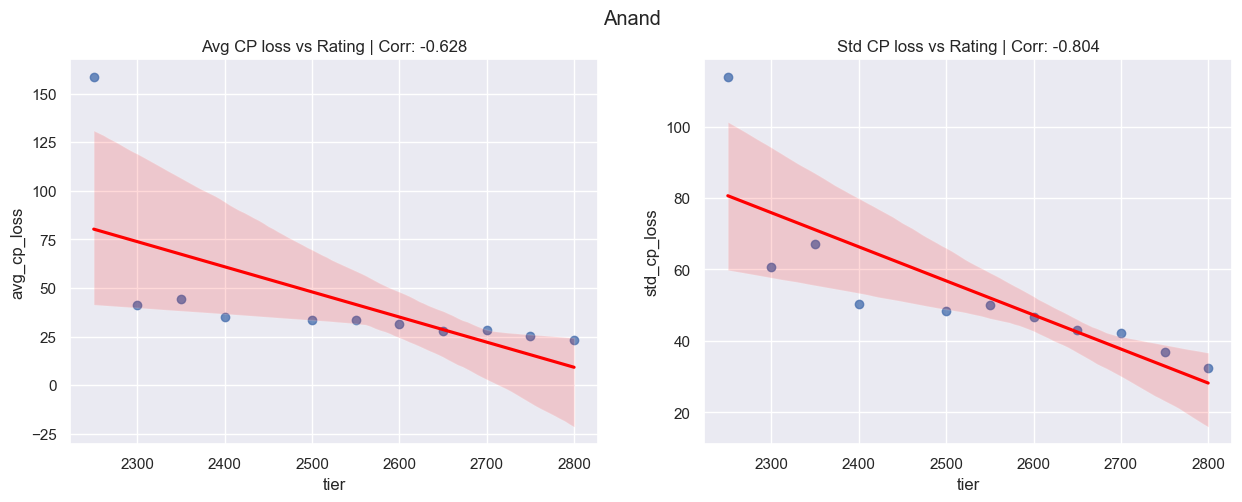

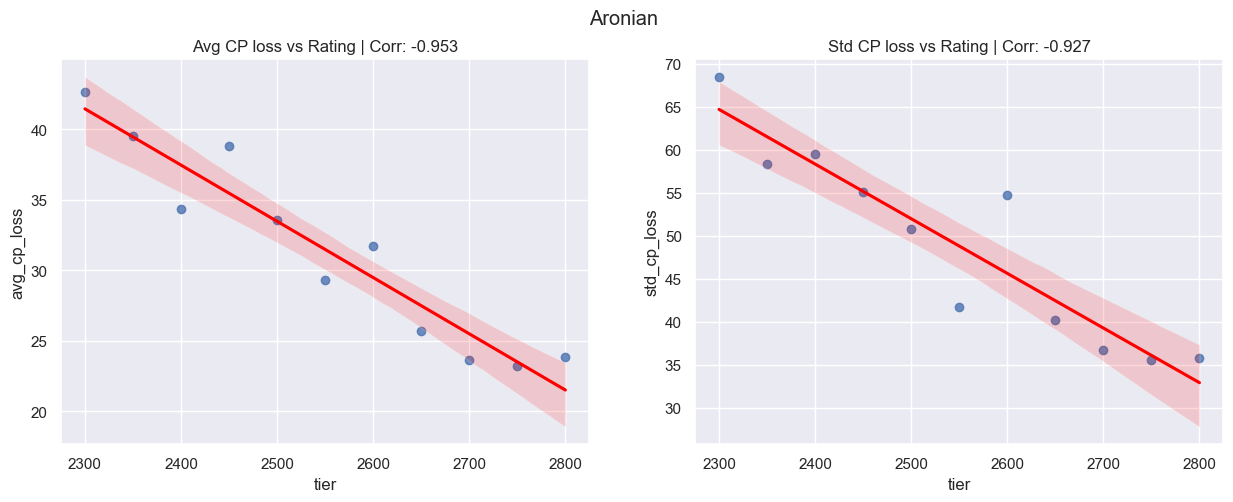

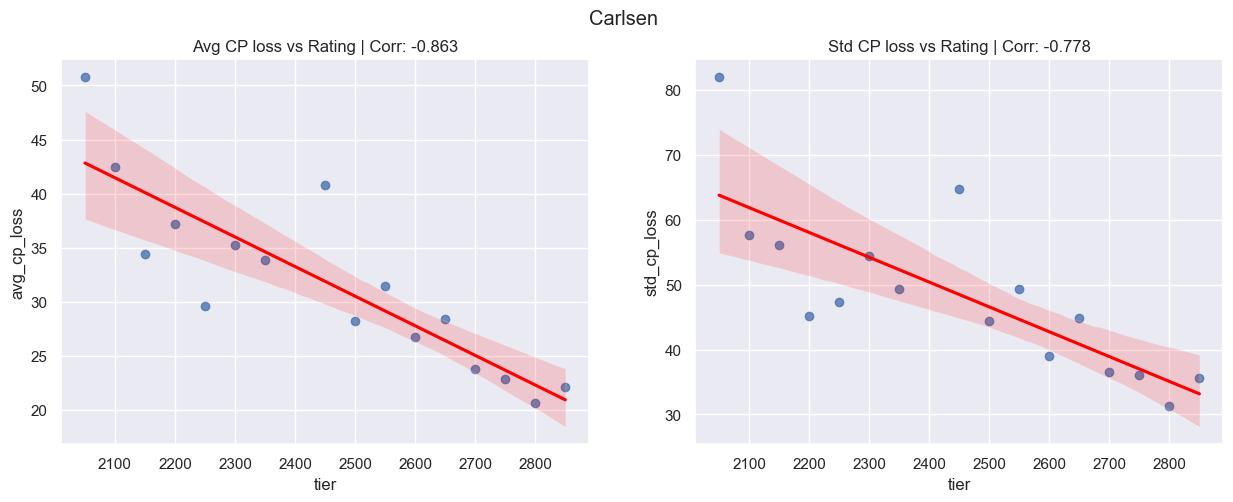

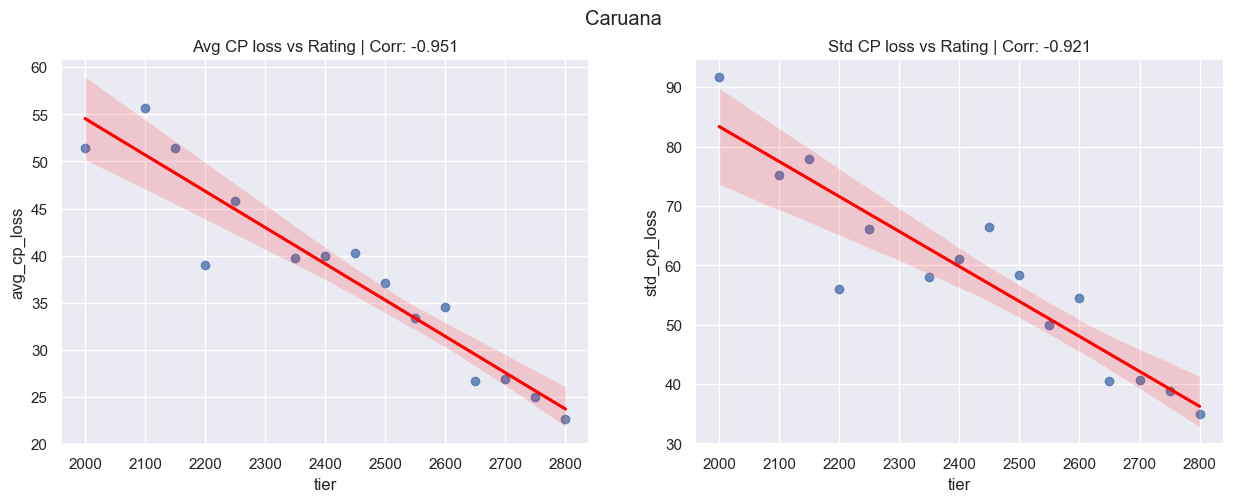

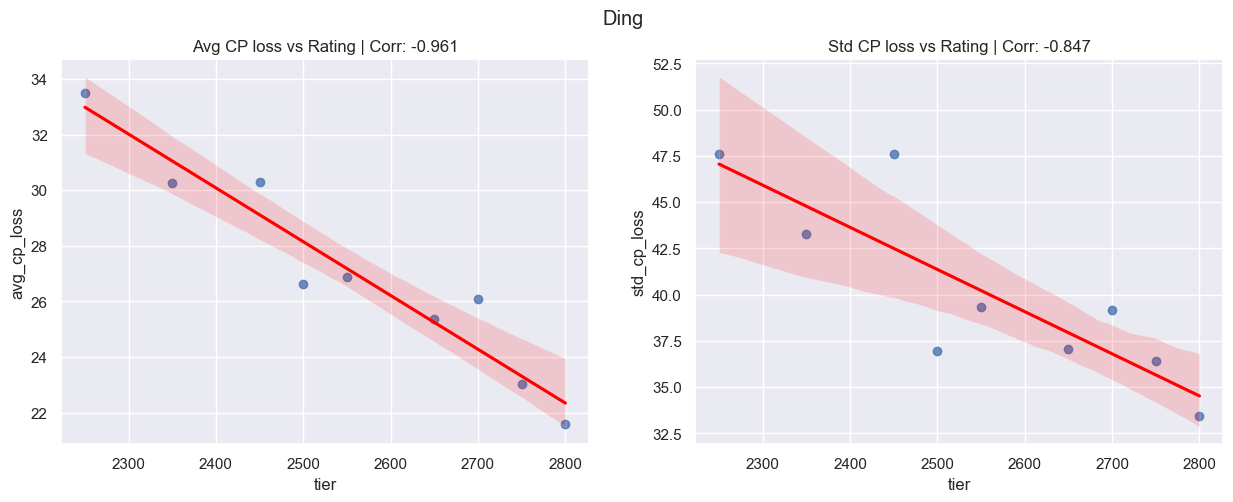

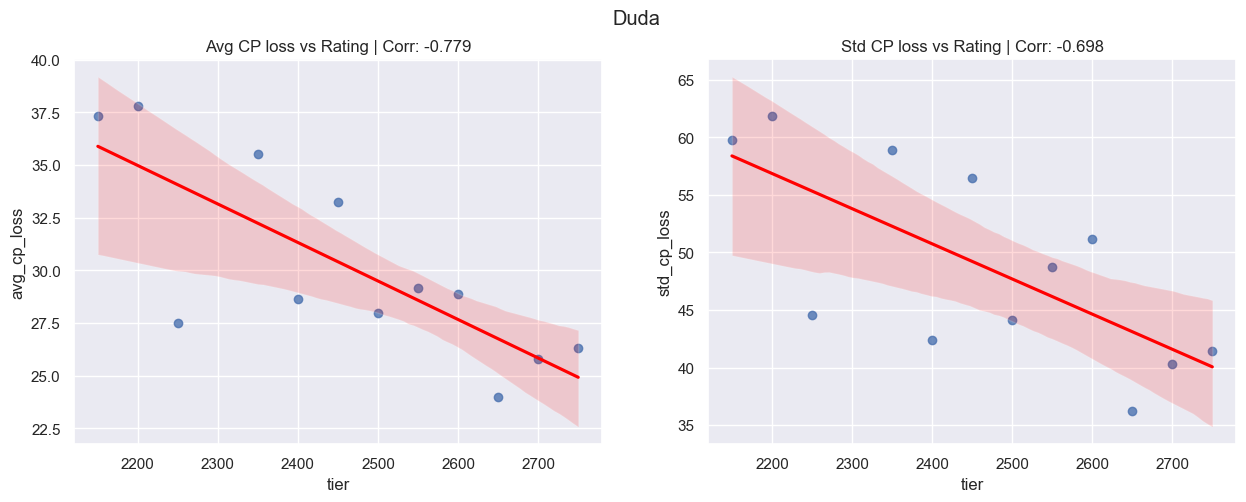

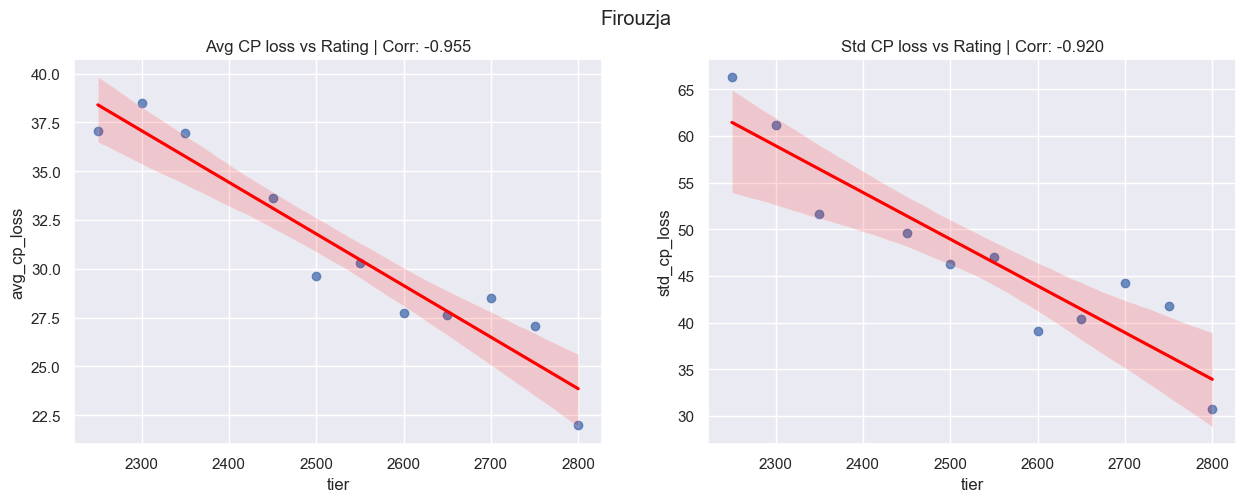

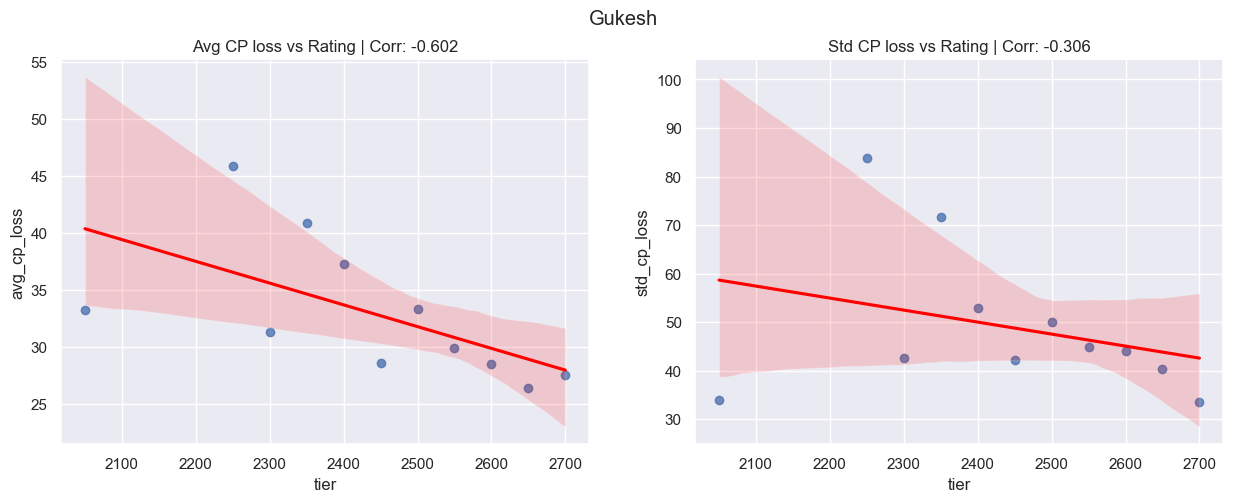

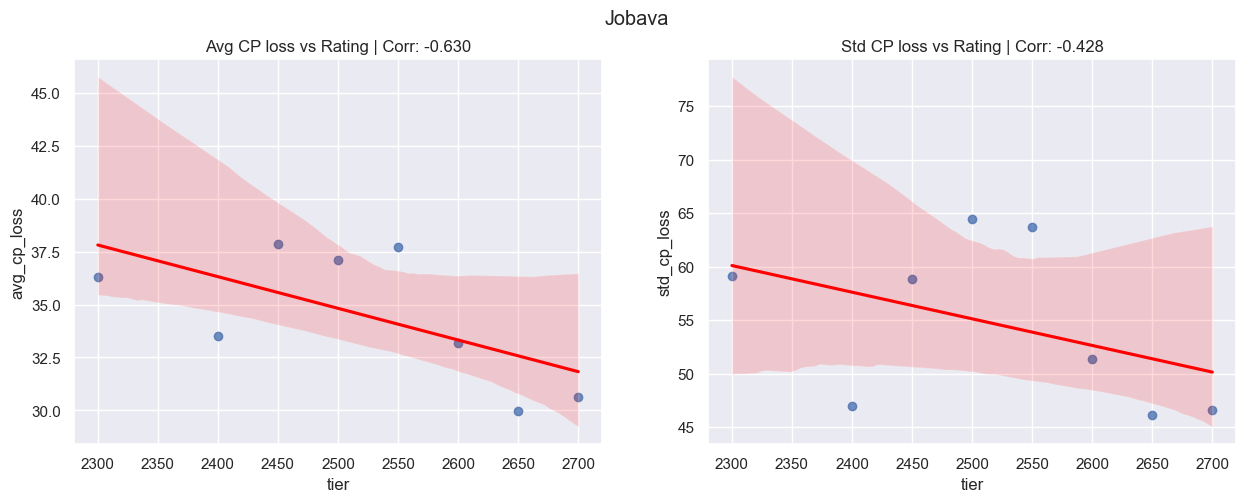

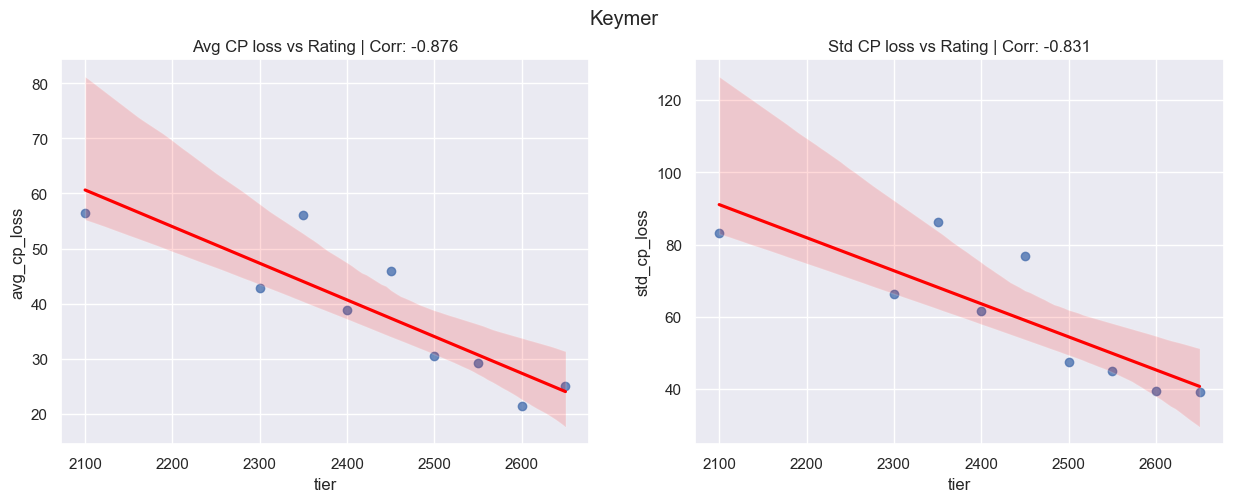

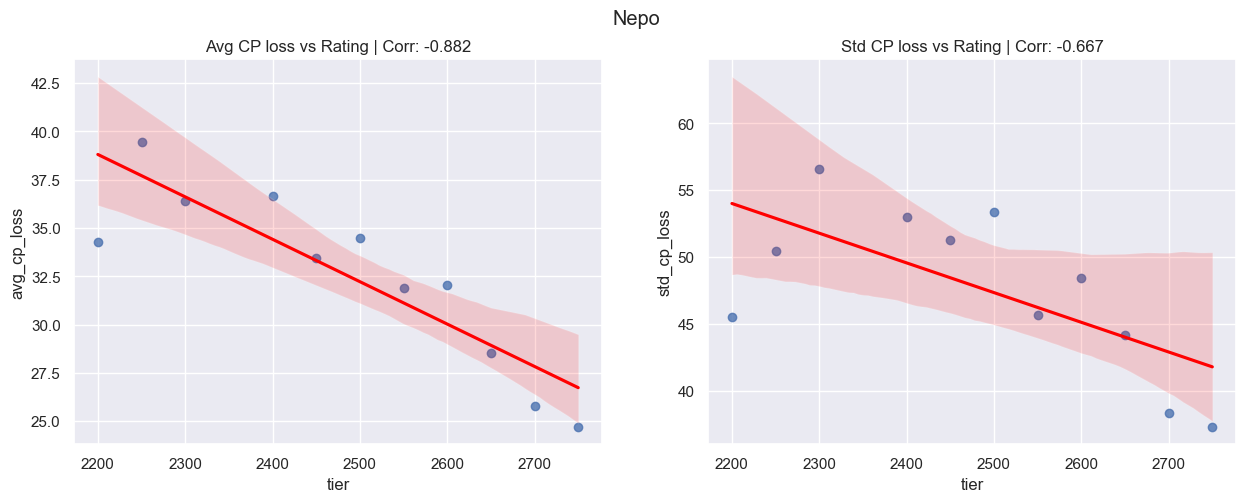

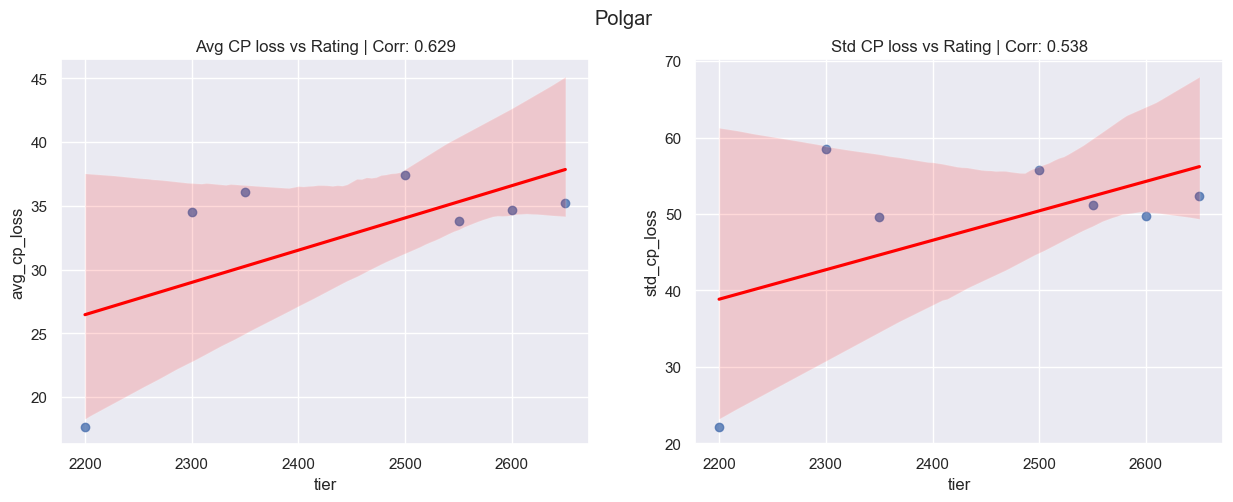

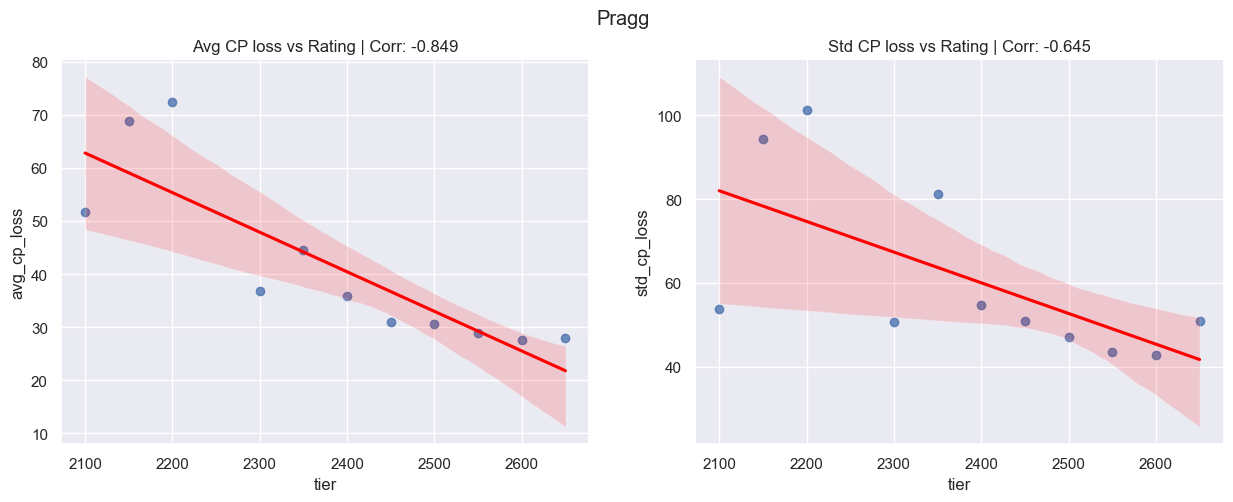

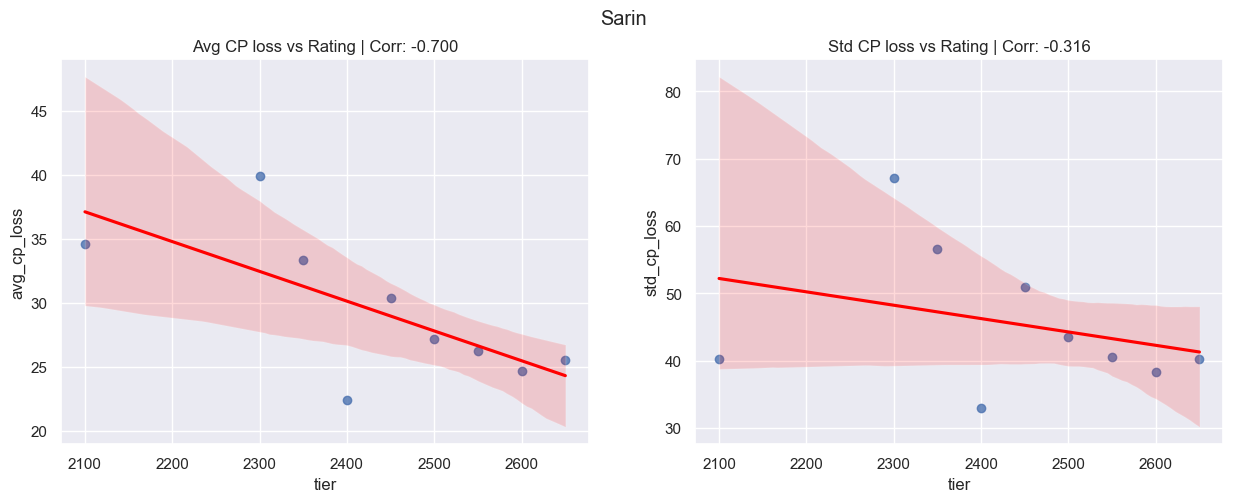

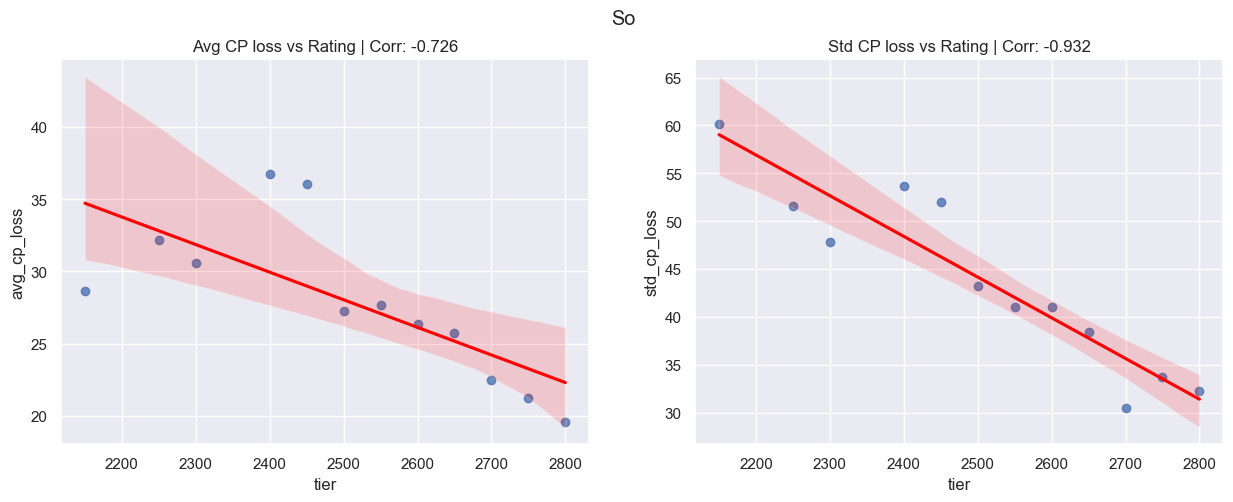

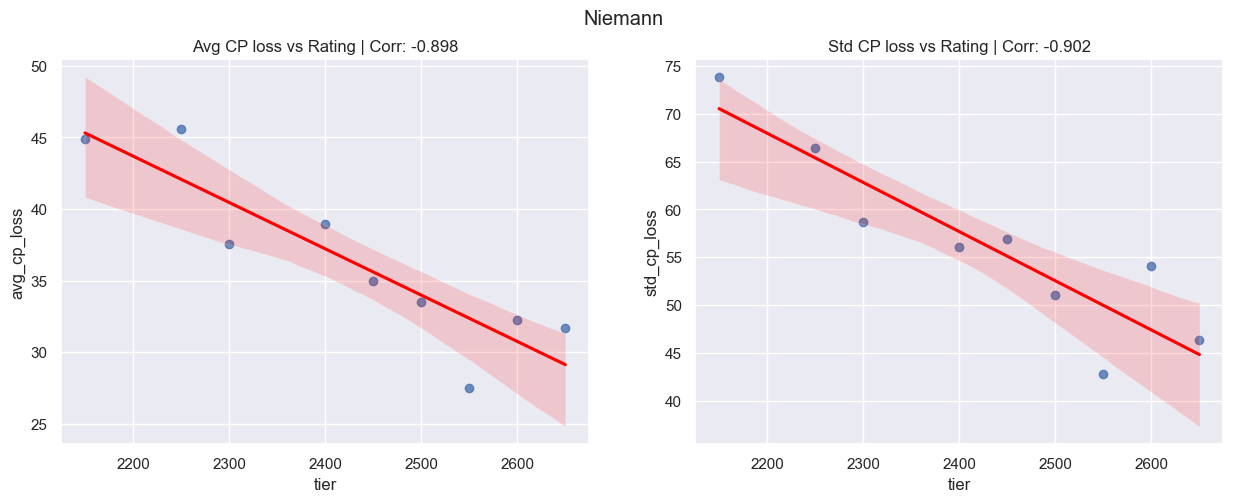

In [39]:
plot_acpl_and_stdcpl_by_tier(df, 'Anand') 
plot_acpl_and_stdcpl_by_tier(df, 'Aronian')
plot_acpl_and_stdcpl_by_tier(df, 'Carlsen')
plot_acpl_and_stdcpl_by_tier(df, 'Caruana')
plot_acpl_and_stdcpl_by_tier(df, 'Ding')
plot_acpl_and_stdcpl_by_tier(df, 'Duda')
plot_acpl_and_stdcpl_by_tier(df, 'Firouzja')
plot_acpl_and_stdcpl_by_tier(df, 'Gukesh')
plot_acpl_and_stdcpl_by_tier(df, 'Jobava')
plot_acpl_and_stdcpl_by_tier(df, 'Keymer')
plot_acpl_and_stdcpl_by_tier(df, 'Nepo')
plot_acpl_and_stdcpl_by_tier(df, 'Polgar')
plot_acpl_and_stdcpl_by_tier(df, 'Pragg')
plot_acpl_and_stdcpl_by_tier(df, 'Sarin')
plot_acpl_and_stdcpl_by_tier(df, 'So')
plot_acpl_and_stdcpl_by_tier(df, 'Niemann')

In [ ]:
cp_loss_limits = [30, 20, 15, 10, 5, 3, 1]
num_games_per_player = df['player'].value_counts().to_dict()
sub_cp_limit_loss_df = pd.DataFrame(df['player'].unique(), columns=['player'])
for cp_loss_limit in cp_loss_limits:
    sub_cp_limit_loss_counts = df.groupby('player')['avg_cp_loss'].apply(lambda x: (x<cp_loss_limit).sum()).to_dict()
    sub_cp_limit_loss_df[f'sub_{cp_loss_limit}'] = sub_cp_limit_loss_df.apply(lambda x: 100*sub_cp_limit_loss_counts[x['player']] / num_games_per_player[x['player']], axis=1)

In [ ]:
for cp_loss_limit in cp_loss_limits:
    title = f'Fraction of games with cp loss sub {cp_loss_limit} (%)'
    sub_cp_limit_loss_df.sort_values(by=[f'sub_{cp_loss_limit}'], ascending=False).plot.bar(x='player', y=f'sub_{cp_loss_limit}', title=title)

In [ ]:
df.sort_values(['avg_cp_loss'], ascending=False).head(10)

In [ ]:
df[df['avg_cp_loss'] > 100].sort_values(['elo'], ascending=False).head(50)

In [ ]:
player_df = df[df['player']=='Ding']
corr = player_df[['elo', 'avg_cp_loss']].corr().iloc[0, 1]
plt.title(f'Avg CP loss vs Rating | Corr: {corr:.3f}');
sns.regplot(x='elo', y='avg_cp_loss', data=player_df) 